In [427]:
import pandas as pd
import datetime
import seaborn as sns
import math
from xgboost import XGBRegressor
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [428]:
shops = pd.read_csv('data/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [429]:
sales_train = pd.read_csv('data/sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [430]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [431]:
#formatting the date column correctly
sales_train['date']=pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

In [432]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [433]:
sales_train.shape

(2935849, 6)

In [434]:
sales_train = sales_train[sales_train['item_cnt_day']>0]
sales_train.shape

(2928493, 6)

In [435]:
sales_train.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [436]:
item_categories = pd.read_csv('data/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [437]:
items = pd.read_csv('data/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [438]:
sales_groupped = sales_train.groupby(['shop_id', 'date']).count()[['item_id']].rename(columns={'item_id':'count'}).reset_index()

In [439]:
sales_groupped.head()

,shop_id,date,count
0,0,2013-01-03,174
1,0,2013-01-04,272
2,0,2013-01-05,236
3,0,2013-01-06,177
4,0,2013-01-07,116


In [440]:
sales_group_by_shop = sales_groupped.groupby('shop_id').count()[['date']].rename(columns={'date':'num_days'}).reset_index()
sales_group_by_shop.head()

,shop_id,num_days
0,0,57
1,1,56
2,2,1018
3,3,1028
4,4,1010


In [441]:
shops_sorted = pd.merge(shops, sales_group_by_shop, on=['shop_id'])

In [442]:
shops_sorted.head()

,shop_name,shop_id,num_days
0,"!Якутск Орджоникидзе, 56 фран",0,57
1,"!Якутск ТЦ ""Центральный"" фран",1,56
2,"Адыгея ТЦ ""Мега""",2,1018
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1028
4,"Волжский ТЦ ""Волга Молл""",4,1010


In [443]:
shops_sorted = shops_sorted.sort_values(by=['num_days'], ascending=False).reset_index(drop=True)

In [444]:
shops_sorted

,shop_name,shop_id,num_days
0,"Воронеж ТРЦ ""Максимир""",7,1034
1,"Омск ТЦ ""Мега""",38,1034
2,"СПб ТК ""Невский Центр""",42,1033
3,"Н.Новгород ТРЦ ""Фантастика""",35,1033
4,"Калуга ТРЦ ""XXI век""",15,1033
5,"Сергиев Посад ТЦ ""7Я""",46,1032
6,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,1032
7,"Ярославль ТЦ ""Альтаир""",59,1032
8,"Уфа ТЦ ""Семья"" 2",53,1031
9,"Москва ТЦ ""Семеновский""",31,1031


In [445]:
assert shops_sorted[shops_sorted['shop_id']==20]['num_days'].iloc[0] == len(sales_train[sales_train['shop_id']==20].groupby(['date']).groups.keys())

### Starting forecasting 

In [446]:
data = sales_train[sales_train['shop_id']==43].drop(columns=['shop_id']).reset_index(drop=True)
data.shape

(39071, 5)

In [447]:
data = data[data['item_cnt_day']>0]
data = data[data['item_price']>0]
data = data.dropna()

In [448]:
data.head()

,date,date_block_num,item_id,item_price,item_cnt_day
0,2013-01-19,0,13482,13990.0,1.0
1,2013-01-21,0,13478,13990.0,1.0
2,2013-01-06,0,13475,8998.0,1.0
3,2013-01-16,0,13462,12990.0,1.0
4,2013-01-26,0,13460,1498.5,1.0


In [449]:
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data.head()

,date,date_block_num,item_id,item_price,item_cnt_day,month,year
0,2013-01-19,0,13482,13990.0,1.0,1,2013
1,2013-01-21,0,13478,13990.0,1.0,1,2013
2,2013-01-06,0,13475,8998.0,1.0,1,2013
3,2013-01-16,0,13462,12990.0,1.0,1,2013
4,2013-01-26,0,13460,1498.5,1.0,1,2013


In [450]:
keep_columns_agg = ['item_id', 'item_price', 'item_cnt_day', 'month', 'year']
data_monthly = data[keep_columns_agg].groupby(['month', 'item_id'], as_index=False).agg(
    {'item_price':'mean', 
     'item_cnt_day':'sum', 
     'year':'max'})

data_monthly = data_monthly.rename(columns={
    'item_price': 'item_price_avg', 
    'item_cnt_day':'item_cnt_month'})

data_monthly = data_monthly.sort_values(by=['year', 'month', 'item_id']).reset_index(drop=True)
data_monthly.head()

,month,item_id,item_price_avg,item_cnt_month,year
0,1,98,399.0,3.0,2013
1,1,471,399.0,1.0,2013
2,1,484,300.0,2.0,2013
3,1,496,4600.0,1.0,2013
4,1,785,349.0,1.0,2013


In [451]:
data_monthly.describe()

,month,item_id,item_price_avg,item_cnt_month,year
count,19738.000000,19738.000000,19738.000000,19738.000000,19738.000000
mean,6.436822,10448.793849,932.033957,2.574881,2013.562367
std,3.646872,6268.964013,1669.416625,7.600516,0.565859
min,1.000000,28.000000,0.100000,1.000000,2013.000000
25%,3.000000,4875.500000,299.000000,1.000000,2013.000000
50%,6.000000,10057.000000,443.470000,1.000000,2014.000000
75%,10.000000,15902.000000,999.000000,2.000000,2014.000000
max,12.000000,22168.000000,28249.500000,380.000000,2015.000000


In [452]:
data_monthly[data_monthly['item_id'] == 471]

,month,item_id,item_price_avg,item_cnt_month,year
1,1,471,399.0,1.0,2013
760,2,471,399.0,1.0,2013
1517,3,471,399.0,1.0,2013
2348,4,471,399.0,1.0,2013
3129,5,471,399.0,1.0,2013


In [453]:
# Build a data set with all the possible combinations to avoid having missing records.
item_ids = data_monthly['item_id'].unique()

start_date = data['date'].min()
end_date = data['date'].max()

start_month = start_date.month
start_year = start_date.year

number_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1

print(start_date)
print(end_date)
print('Number of months is {}'.format(number_of_months))

empty_df = []
cur_month = start_month
cur_year = start_year

for i in range(number_of_months):
    for item in item_ids:
        empty_df.append([cur_month, cur_year, item])
    
    add_12_if_receive_0 = (12 - 12*math.ceil((cur_month+1)%12 / 12))
    cur_month = (cur_month+1)%12 + add_12_if_receive_0
    
    if cur_month == 1:
        cur_year += 1
    
empty_df = pd.DataFrame(empty_df, columns=['month','year','item_id'])

2013-01-03 00:00:00
2015-01-25 00:00:00
Number of months is 25


In [454]:
# missing records will be filled with 0s
data_monthly_ext = pd.merge(empty_df, data_monthly, on=['month','year','item_id'], how='left')
data_monthly_ext.fillna(0, inplace=True)
data_monthly_ext = data_monthly_ext.sort_values(by=['year', 'month', 'item_id']).reset_index(drop=True)

In [455]:
data_monthly_ext.head()

,month,year,item_id,item_price_avg,item_cnt_month
0,1,2013,28,0.0,0.0
1,1,2013,30,0.0,0.0
2,1,2013,31,0.0,0.0
3,1,2013,32,0.0,0.0
4,1,2013,33,0.0,0.0


In [456]:
# add date_block to split data into train and test
data_monthly_ext['date_block_num'] = data_monthly_ext.apply(lambda row: (row['year']*12 + row['month'])- (start_year*12 + start_month), axis=1)

In [457]:
data_monthly_ext[data_monthly_ext['item_id'] == 471]

,month,year,item_id,item_price_avg,item_cnt_month,date_block_num
27,1,2013,471,399.0,1.0,0.0
6764,2,2013,471,399.0,1.0,1.0
13501,3,2013,471,399.0,1.0,2.0
20238,4,2013,471,399.0,1.0,3.0
26975,5,2013,471,399.0,1.0,4.0
33712,6,2013,471,0.0,0.0,5.0
40449,7,2013,471,0.0,0.0,6.0
47186,8,2013,471,0.0,0.0,7.0
53923,9,2013,471,0.0,0.0,8.0
60660,10,2013,471,0.0,0.0,9.0


In [458]:
data_monthly_ext['itm_cnt_nxt_mnth'] = data_monthly_ext.groupby(['item_id'])['item_cnt_month'].shift(-1)
data_monthly_ext.head()

,month,year,item_id,item_price_avg,item_cnt_month,date_block_num,itm_cnt_nxt_mnth
0,1,2013,28,0.0,0.0,0.0,0.0
1,1,2013,30,0.0,0.0,0.0,14.0
2,1,2013,31,0.0,0.0,0.0,0.0
3,1,2013,32,0.0,0.0,0.0,0.0
4,1,2013,33,0.0,0.0,0.0,0.0


In [459]:
data_monthly_ext.shape

(168425, 7)

In [460]:
data_monthly_ext = data_monthly_ext.dropna()

In [461]:
data_monthly_ext.shape

(161688, 7)

In [462]:
data_monthly_ext = pd.merge(data_monthly_ext, items, on=['item_id'], how='left')
data_monthly_ext = pd.merge(data_monthly_ext, item_categories, on=['item_category_id'], how='left')
data_monthly_ext.head()

,month,year,item_id,item_price_avg,item_cnt_month,date_block_num,itm_cnt_nxt_mnth,item_name,item_category_id,item_category_name
0,1,2013,28,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания
1,1,2013,30,0.0,0.0,0.0,14.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD
2,1,2013,31,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray
3,1,2013,32,0.0,0.0,0.0,0.0,1+1,40,Кино - DVD
4,1,2013,33,0.0,0.0,0.0,0.0,1+1 (BD),37,Кино - Blu-Ray


In [463]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    data_monthly_ext[('item_cnt_%s' % function_name[i])] = data_monthly_ext.sort_values(by=['year', 'month']).groupby(['item_category_id', 'item_id'])['item_cnt_month'].apply(function_list[i])

# Fill the empty std features with 0
data_monthly_ext['item_cnt_std'].fillna(0, inplace=True)

In [464]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    data_monthly_ext[ft_name] = data_monthly_ext.sort_values('date_block_num').groupby(['item_category_id', 'item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    data_monthly_ext[ft_name].fillna(0, inplace=True)

In [465]:
data_monthly_ext['item_trend'] = data_monthly_ext['item_cnt_month']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    data_monthly_ext['item_trend'] -= data_monthly_ext[ft_name]

data_monthly_ext['item_trend'] /= len(lag_list) + 1

In [478]:
data_monthly_ext.head()

,month,year,item_id,item_price_avg,item_cnt_month,date_block_num,itm_cnt_nxt_mnth,item_name,item_category_id,item_category_name,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,1,2013,28,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2013,30,0.0,0.0,0.0,14.0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2013,31,0.0,0.0,0.0,0.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2013,32,0.0,0.0,0.0,0.0,1+1,40,Кино - DVD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2013,33,0.0,0.0,0.0,0.0,1+1 (BD),37,Кино - Blu-Ray,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [466]:
# calculate date_block_num for splitting

In [467]:
train_set = data_monthly_ext.query('date_block_num >= 3 and date_block_num < 20').copy()
validation_set = data_monthly_ext.query('date_block_num >= 20 and date_block_num < 23').copy()
test_set = data_monthly_ext.query('date_block_num >= 23').copy()

train_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)
validation_set.dropna(subset=['itm_cnt_nxt_mnth'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/data_monthly_ext.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/data_monthly_ext.shape[0])*100)))

Train set records: 114529
Validation set records: 20211
Test set records: 6737
Train set records: 114529 (71% of complete data)
Validation set records: 20211 (12% of complete data)


In [468]:
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'itm_cnt_nxt_mnth': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add mean encoding features to train set.
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [469]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
Y_train = train_set['itm_cnt_nxt_mnth'].astype(int)
X_validation = validation_set.drop(['itm_cnt_nxt_mnth', 'date_block_num'], axis=1)
Y_validation = validation_set['itm_cnt_nxt_mnth'].astype(int)

In [470]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
#X_test.drop(['item_category_id'], axis=1, inplace=True)

In [487]:
# Use only part of features on XGBoost.
xgb_features = ['month_mean', 'year_mean', 'item_mean', 'item_cnt_month','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'item_trend', 'year', 'month']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
#xgb_test = X_test[xgb_features]

In [488]:
xgb_model = XGBRegressor()
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[03:59:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.46092	validation_1-rmse:4.49576
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:1.91583	validation_1-rmse:3.43362
[40]	validation_0-rmse:1.75994	validation_1-rmse:3.3655
Stopping. Best iteration:
[36]	validation_0-rmse:1.77087	validation_1-rmse:3.35744



XGBRegressor()

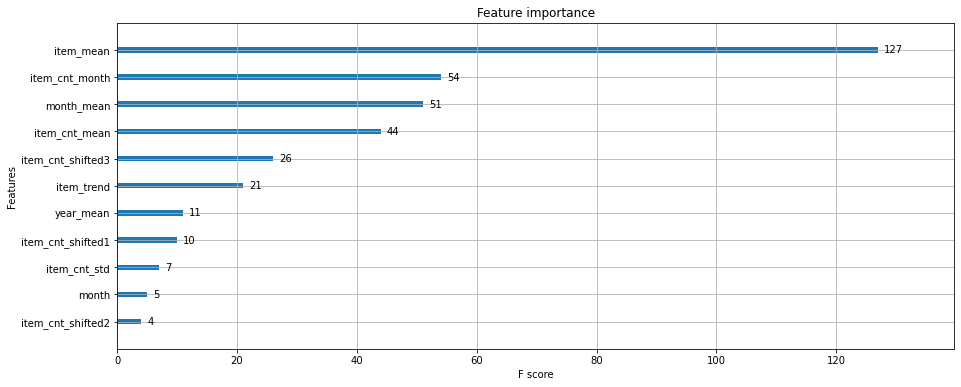

In [489]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [490]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
#xgb_test_pred = xgb_model.predict(xgb_test)

In [491]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 1.7712322446182869
Validation rmse: 3.3576367884790184


In [476]:
#X = data_monthly_ext.drop(columns=['itm_cnt_nxt_mnth'])

In [477]:
#y = data_monthly_ext[['itm_cnt_nxt_mnth']]